In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
from tools import *

# Professor tips:
import pdb # pdb.set_trace() -> user for debugging, stop code in a line and see the variables ...

# To reload external python files
# "%load_ext autoreload"
# "%autoreload 2" (to reload supplementary files like tools.py every 2 seconds for example, "useful when debugging with prints etc...")

# Partie 1 : SIFT

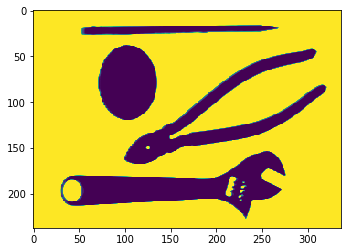

In [2]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I)

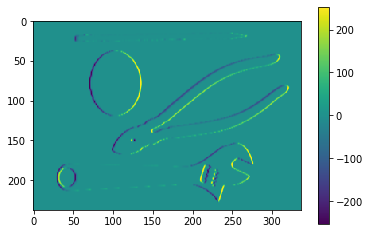

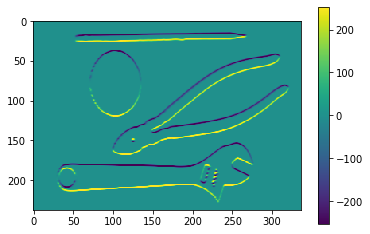

In [3]:
def compute_grad(I):
    ha = np.matrix([[0.5], [1], [0.5]])
    hb = np.matrix([[-0.5], [0], [0.5]])
    Ix = conv_separable(I, hb, ha)
    Iy = conv_separable(I, ha, hb)
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [4]:
def compute_grad_mod_ori(I):
    Ix, Iy = compute_grad(I)
    Gm = (Ix**2 + Iy**2)**(0.5)
    Go = compute_grad_ori(Ix, Iy, Gm)
    return Gm, Go

In [5]:
# Compute SIFT over a patch
# Assuming Gm and Go are already 16x16 in size
def compute_sift_region(Gm, Go, mask=None):
    
    if mask is not None:
        Gm = np.multiply(Gm, mask)
    
    def compute_subregion(Gm, Go):
        Renck = np.zeros(8)
        for i in range(Gm.shape[0]):
            for j in range(Gm.shape[1]):
                Renck[Go[i,j]] += Gm[i,j]
        return Renck
    
    Penck = np.array([])
    for j in range(4):
        for i in range(4):
            Gmp = Gm[i*4:(i+1)*4,j*4:(j+1)*4]
            Gop = Go[i*4:(i+1)*4,j*4:(j+1)*4]
            Penck = np.concatenate((Penck, compute_subregion(Gmp, Gop)))
    
    Penck_norm = np.linalg.norm(Penck)
    
    if (Penck_norm < 0.5):
        return np.zeros(128)
    
    Penck = Penck / Penck_norm
    Penck = np.vectorize(lambda t: 0.2 if t > 0.2 else t)(Penck)
    Penck_norm = np.linalg.norm(Penck)
    Penck = Penck / Penck_norm
            
    return Penck

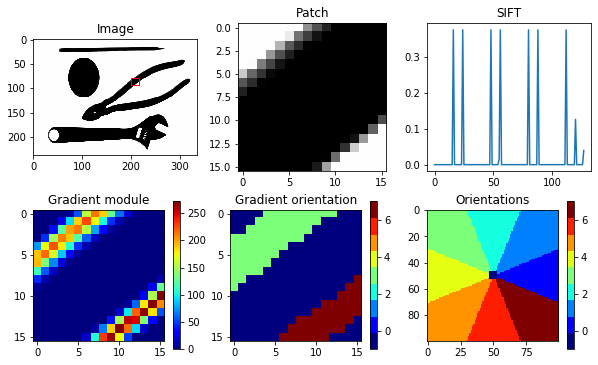

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.37462778, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.37462778,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.37462778, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01578843, 0.37462778, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [6]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I,             compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
# display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
# display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
# display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
# display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
# display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [7]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    Gm, Go = compute_grad_mod_ori(im)
    
    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            sifts[i, j, :] = compute_sift_region(Gm[xi:xi+16, yj:yj+16], Go[xi:xi+16, yj:yj+16], gaussian_mask()) # done
            # print('sift: ', sifts[i,j])
    return sifts

# Partie 2 : Dictionnaire visuel

In [8]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
from tools import *
from sift import *
from sklearn.cluster import KMeans

In [9]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift')
path_vdict = os.path.join('data', 'kmeans', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')

inames, ilabls, cnames = load_dataset(dir_sc)

In [10]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


In [11]:
# Code here the `compute_visual_dict` function - # done
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    
    # Compute kmeans on `sift`, get cluster centers, add zeros vector - # done
    kmeans = KMeans(n_clusters = n_clusters, init = 'random').fit(sift)
    cluster_centers = kmeans.cluster_centers_
    zero_cluster_center = np.zeros(128).reshape(1, -1)
    cluster_centers = np.append(cluster_centers, zero_cluster_center, axis=0)
    
    return cluster_centers

In [17]:
# Understanding "sifts_list_by_image"
print(len(sifts_list_by_image)) # number of images
print(len(sifts_list_by_image[0])) # number of nx (patches along x-axis)
print(len(sifts_list_by_image[0][0])) # number of ny (patches along y-axis)
print(len(sifts_list_by_image[0][0][0])) # 128 size array encoding each one of the patches

# compute_visual_dict(sifts_list_by_image)

4485
28
42
128


In [18]:
# Run the visual dict computation (saved the first time)
vidct = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict


In [19]:
for w in vidct[0:5]:
    print(w[0:15])

[42.56354385  7.9952856   3.6693305   3.32003335 10.68807313  2.81107885
  3.29881852  7.92212608 54.87455084  8.22623394  3.2601834   2.5548337
  9.09063731  2.6348636   3.65349125]
[ 4.09837072  4.88733086 21.48249517  5.08213924  4.94246878  6.62004848
 35.14405818  6.09487282  3.7678807   4.75269246 22.7410328   4.87447455
  4.21048756  6.66941794 37.18477494]
[17.47242512  5.29113209  4.73050922  6.86581971 24.82431612  7.45595345
  5.78923795  6.1389104  16.92006949  4.99702798  4.2016367   7.06255886
 28.91703468  8.03869901  5.12289918]
[ 9.48487346  6.45015999 11.85978862  5.97013478  8.02860467  5.13279356
 10.10685543  5.48104334  9.04678561  6.23189179 11.89265975  5.94041501
  7.96858334  5.29385242 10.04024047]
[14.78325668 11.62040224 12.7894801  12.98625367 17.75140864 12.51354836
 11.74341871 11.4824516  14.08510746 12.03182773 13.14346339 13.24238825
 16.46785247 12.34959746 11.55591427]


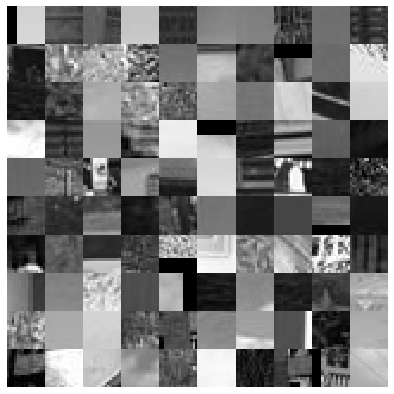

In [15]:
# Study of the dict
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 30)) # Compute SIFT and regions from 30 random images
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

In [20]:
n_clusters = vidct.shape[0]
print('n_clusters', n_clusters)
print('vidct.shape', vidct.shape)

# regions, sifts
print('regions.shape: ', regions.shape)
print('sifts.shape: ', sifts.shape)

n_clusters 6
vidct.shape (6, 128)
regions.shape:  (31372, 16, 16)
sifts.shape:  (31372, 128)


In [21]:
# Visually analyze the dict through similar example regions - # doing TODO
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

def find_closest_region_to_a_sift(regions, regions_sifts, target_sift):
    distance_vectors = regions_sifts - target_sift
    distances = []
    for v in distance_vectors:
        distances.append(np.linalg.norm(v))
    closest_region_index = np.argmin(distances)
    return regions[closest_region_index]

def get_vdregions(regions, regions_sifts, vidct):
    vdregions_list = []
    for visual_word in vidct:
        vdregions_list.append(find_closest_region_to_a_sift(regions, regions_sifts, visual_word))
    return np.array(vdregions_list)

vdregions = get_vdregions(regions, sifts, vidct)
print('vdregions.shape: ', vdregions.shape)

vdregions.shape:  (6, 16, 16)


Nine closest regions to cluster center  0 :



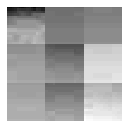

Nine closest regions to cluster center  1 :



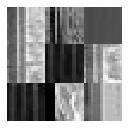

Nine closest regions to cluster center  2 :



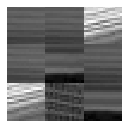

Nine closest regions to cluster center  3 :



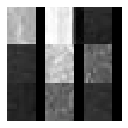

Nine closest regions to cluster center  4 :



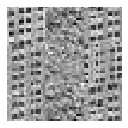

Nine closest regions to cluster center  5 :



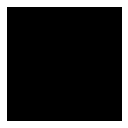

In [22]:
# More auxiliary fucntions for visualization:

def find_k_closest_regions_to_a_sift(regions, regions_sifts, target_sift, k):
    distance_vectors = regions_sifts - target_sift
    distances = []
    for v in distance_vectors:
        distances.append(np.linalg.norm(v))
    d_copy = distances.copy()
    d_copy.sort()
    closest_k_regions_index = []
    for i in range(k):
        k_min_index = distances.index(d_copy[i])
        closest_k_regions_index.append(k_min_index)
    return regions[closest_k_regions_index]

def print_regions_closest_to_clusters_centers():
    for i in range(n_clusters):
        ans = np.array([find_closest_region_to_a_sift(regions, sifts, vidct[i])])
        print('Closest region to cluster center ', i, ' is:\n')
        display_images(ans)

def print_9_closest_regions_to_a_cluster_center(regions, regions_sifts, cluster_center):
    closest_regions = find_k_closest_regions_to_a_sift(regions, regions_sifts, cluster_center, 9)
    display_images(closest_regions)

def print_9_closest_regions_to_every_cluster_center(regions, regions_sifts, cluster_centers):
    for i in range(len(cluster_centers)):
        print('Nine closest regions to cluster center ', i, ':\n')
        print_9_closest_regions_to_a_cluster_center(regions, regions_sifts, cluster_centers[i])

def print_9_closest_regions_to_6_first_cluster_center(regions, regions_sifts, cluster_centers):
    for i in range(6):
        print('Nine closest regions to cluster center ', i, ':\n')
        print_9_closest_regions_to_a_cluster_center(regions, regions_sifts, cluster_centers[i])
        
# Uncomment the line you want below:
# print_regions_closest_to_clusters_centers()
# print_9_closest_regions_to_a_cluster_center(regions, sifts, vidct[2])
# print_9_closest_regions_to_every_cluster_center(regions, sifts, vidct)
print_9_closest_regions_to_6_first_cluster_center(regions, sifts, vidct)


# Partie 3 : BoW

In [23]:
# Compute BoW for an image

def compute_feats(vdict, image_sifts):
    # reorder data
    dim_sift = image_sifts.shape[-1]
    im_sifts = image_sifts.reshape(-1, dim_sift)
    
    vdict = vdict / 255
    
    # print('im_sifts.shape: ', im_sifts.shape)
    
    # compute BoW from `image_sifts` - done
    # coding
    H = []
    for sift in im_sifts:
        #distances = list(map(np.linalg.norm, vdict-sift))
        distances_vectors = vdict-sift
        distances = []
        for v in distances_vectors:
            distances.append(np.linalg.norm(v))
        
        # print('distances: ', distances, '\n')
        
        cluster_index = np.argmin(distances)
        one_hot = np.zeros(len(vdict))
        one_hot[cluster_index] = 1
        H.append(one_hot)
    H = np.array(H)
    
    # print('H: ', H)
    
    # pooling
    z = np.sum(H, axis=0)
    
    # print('z: ', z)
    
    # normalization
    z = z / (np.linalg.norm(z))
    
    # print('z normalized: ', z)
    
    return z

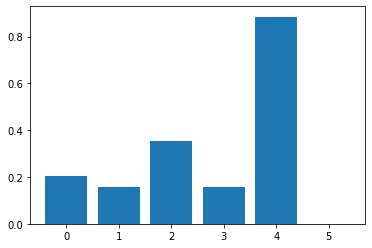

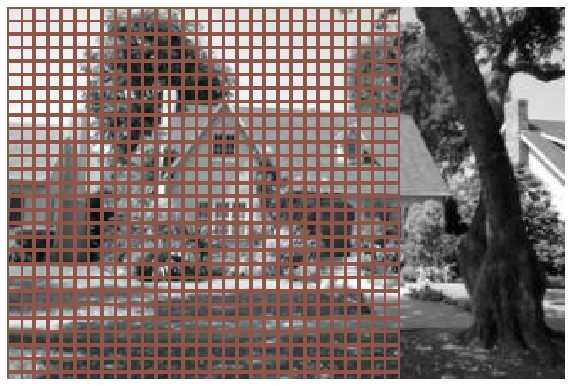

(6, 16, 16)


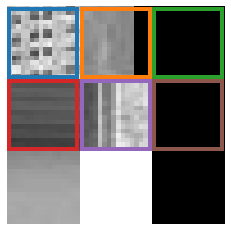

In [24]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)

# print(sift.shape)
# sift = sift.reshape(-1, 128)
# print(sift.shape)

regions = compute_regions(im)
feats = compute_feats(vidct, sift)

display_vdregions_image(im, vidct, sift, feats, vdregions=vdregions) # if you have vdregions, add it as input here